Load Data: https://www.kaggle.com/rmisra/news-category-dataset/code?datasetId=32526&searchQuery=df+%3D+pd.read_json%28file_path%2C+lines+%3D+True%29

Main Code: https://www.kaggle.com/hengzheng/news-category-classifier-val-acc-0-65

Additional sources (preprocessing):

*  https://galhever.medium.com/sentiment-analysis-with-pytorch-part-1-data-preprocessing-a51c80cc15fb
* https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470
* https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [3]:
import pandas as pd
import string
import re
st = string.punctuation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stopword = nltk.corpus.stopwords.words('english')
import itertools

def load_data(file_path):
    df = pd.read_json(file_path, lines = True)
    df['category'] = pd.Categorical(df['category'])
    df = df[df["short_description"] != ""]
    df['headlineDesc'] = df['headline']+ ' ' + df['short_description']
    return df[["headlineDesc", "category"]]

df = load_data('News_Category_Dataset_v2.json')

col = ['category', 'headlineDesc']
df = df[col]
df = df[pd.notnull(df['headlineDesc'])]
df.columns = ['category', 'headlineDesc']
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)


#https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470
#https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
def remove_punctuation(text,st):
    #shouldn't need to because of keras but additional check
    no_punct=[words for words in text if words not in st]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

def tokenize(text):
    #convert string to list
    split=re.split("\W+",text) 
    return split

def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

def stem_lem(text):
  ## Stemming (remove -ing, -ly, ...) ## Lemmatisation (convert the word into root word)
  ps = nltk.stem.porter.PorterStemmer()
  lst_text = [ps.stem(word) for word in text]
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  lst_text = [lem.lemmatize(word) for word in lst_text]
  return lst_text

df['mainDesc']=df['headlineDesc'].apply(lambda x: remove_punctuation(x,st))
df['mainDesc']=df['mainDesc'].apply(lambda x: tokenize(x.lower()))
df['mainDesc'] = df['mainDesc'].apply(lambda x: remove_stopwords(x))
df['mainDesc'] = df['mainDesc'].apply(lambda x: stem_lem(x))
df['main'] = df['mainDesc'].apply(lambda x: ' '.join(str(x) for x in x))
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,category,headlineDesc,category_id,mainDesc,main
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,0,"[2, mass, shoot, texa, last, week, 1, tv, left...",2 mass shoot texa last week 1 tv left husband ...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,1,"[smith, join, diplo, nicki, jam, 2018, world, ...",smith join diplo nicki jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,1,"[hugh, grant, marri, first, time, age, 57, act...",hugh grant marri first time age 57 actor longt...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,1,"[jim, carrey, blast, castrato, adam, schiff, d...",jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,1,"[julianna, marguli, use, donald, trump, poop, ...",julianna marguli use donald trump poop bag pic...


In [4]:
#different than baseline (keras instead of spacy)
from keras.preprocessing.text import Tokenizer
# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.main)
X = tokenizer.texts_to_sequences(df.main)
df['words'] = X
vocab_size = len(tokenizer.word_index) + 1
# delete some empty and short data
df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

In [5]:
from keras.preprocessing import sequence
import numpy as np
maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))
categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 79516 unique tokens.
Total 400000 word vectors.


In [6]:
from keras import layers
from keras.initializers import Constant
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

# split to training set, validation set, test
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed) # 0.25 x 0.8 = 0.2

In [9]:
from keras.models import Sequential, Model
from keras.backend import clear_session
clear_session()

from tensorflow.keras import models
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
inp = layers.Input(shape=(maxlen,), dtype='int32')
embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

## embedding
x = embedding_layer(inp)
## apply attention
x = attention_layer(x, neurons=50)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.5, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(41, activation='softmax')(x)
## compile
model = models.Model(inp, y_out)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      7951700     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 100, 50)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 100, 50)      2550        ['permute[0][0]']                
                                                                                              

In [10]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/30
1698/1698 [==============================] - 34s 17ms/step - loss: 2.6855 - accuracy: 0.3102 - val_loss: 2.3230 - val_accuracy: 0.3857
Epoch 2/30
1698/1698 [==============================] - 27s 16ms/step - loss: 2.3009 - accuracy: 0.3923 - val_loss: 2.1405 - val_accuracy: 0.4278
Epoch 3/30
1698/1698 [==============================] - 28s 16ms/step - loss: 2.1864 - accuracy: 0.4175 - val_loss: 2.0549 - val_accuracy: 0.4500
Epoch 4/30
1698/1698 [==============================] - 27s 16ms/step - loss: 2.1065 - accuracy: 0.4344 - val_loss: 1.9804 - val_accuracy: 0.4672
Epoch 5/30
1698/1698 [==============================] - 27s 16ms/step - loss: 2.0445 - accuracy: 0.4513 - val_loss: 1.9358 - val_accuracy: 0.4787
Epoch 6/30
1698/1698 [==============================] - 27s 16ms/step - loss: 1.9966 - accuracy: 0.4625 - val_loss: 1.8856 - val_accuracy: 0.4901
Epoch 7/30
1698/1698 [==============================] - 28s 16ms/step - loss: 1.9593 - accuracy: 0.4706 - val_loss: 1.8543 -

In [11]:
#https://www.tensorflow.org/guide/keras/train_and_evaluate
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
566/566 [==============================] - 4s 7ms/step - loss: 1.6049 - accuracy: 0.5567
test loss, test acc: [1.604931354522705, 0.5566571950912476]


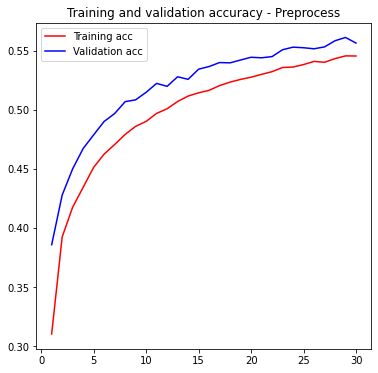

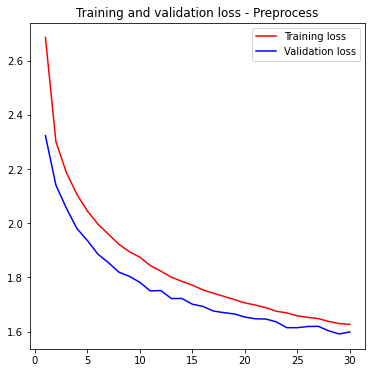

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy - Preprocess')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()
plt.savefig("train_val_preprocess_acc.png")
plt.figure()
plt.title('Training and validation loss - Preprocess')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.savefig("train_val_preprocess_loss.png")
plt.show()